## Predicting Salary of a job position based on various attributes

**Importing libraries**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from functions import *
from data_preparation import *

In [24]:
%matplotlib inline

**Importing the dataset**

In [26]:
dataset = pd.read_csv("Salaries.csv")

** Exploratory Analysis**

In [27]:
dataset.columns

Index(['Job code', 'Company', 'Experience', 'Distance', 'Highest Degree',
       'Major Subject', 'Designation ', 'Domain', 'Salary'],
      dtype='object')

**Some columns like 'Job code', 'Highest Degree' have spaces in between and "Designation ' has a space in the end. These initial data handling errors should be corrected to avoid problems while referring to columns and allow easy access. Therefore we need to remove unnecessary spaces from columns names<br> We can also use underscores, I am choosing to replace them with an empty string**

In [28]:
dataset.columns = dataset.columns.str.replace('\s+', '')  # in case there are multiple white spaces

In [31]:
dataset.columns

Index(['Jobcode', 'Company', 'Experience', 'Distance', 'HighestDegree',
       'MajorSubject', 'Designation', 'Domain', 'Salary'],
      dtype='object')

In [32]:
dataset.shape

(1000000, 9)

**We have 6 string (object) columns and 3 continuous int columns<br>Also we do not have anu missing values**

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
Jobcode          1000000 non-null object
Company          1000000 non-null object
Experience       1000000 non-null int64
Distance         1000000 non-null int64
HighestDegree    1000000 non-null object
MajorSubject     1000000 non-null object
Designation      1000000 non-null object
Domain           1000000 non-null object
Salary           1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [34]:
f = functions()

** Further evaluating string columns **

In [35]:
f.string_col_count('Company', dataset)
f.string_col_count('HighestDegree', dataset)
f.string_col_count('MajorSubject', dataset)
f.string_col_count('Designation', dataset)

Company has 63 unique values
HighestDegree has 5 unique values
MajorSubject has 9 unique values
Designation has 8 unique values


**Checking the distribution of each column**

* **Highest degree is almost uniformly distributed, None is value which can be dealt with in different ways but we will keep it as is for now**<br>
* **Major SUbject is almost perfectly uniformly distributed except for None which is extremely high but we would keep it for now**
* **Designation is almost perfectly uniformly distributed**
* **Domain is almost perfectly uniformly distributed**

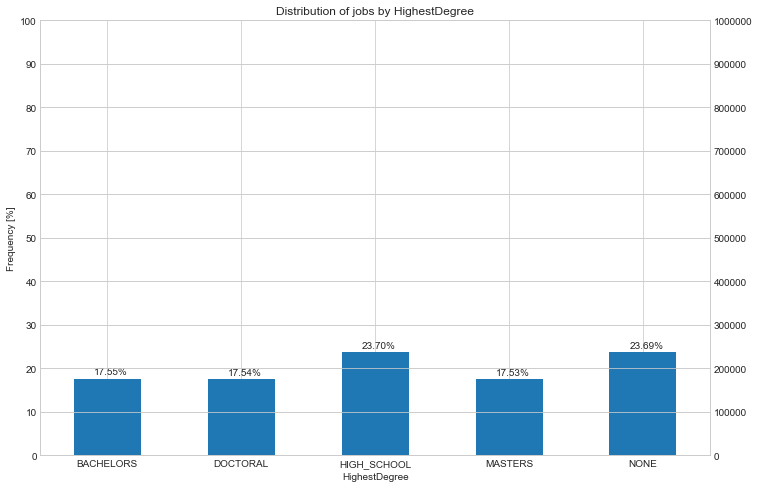

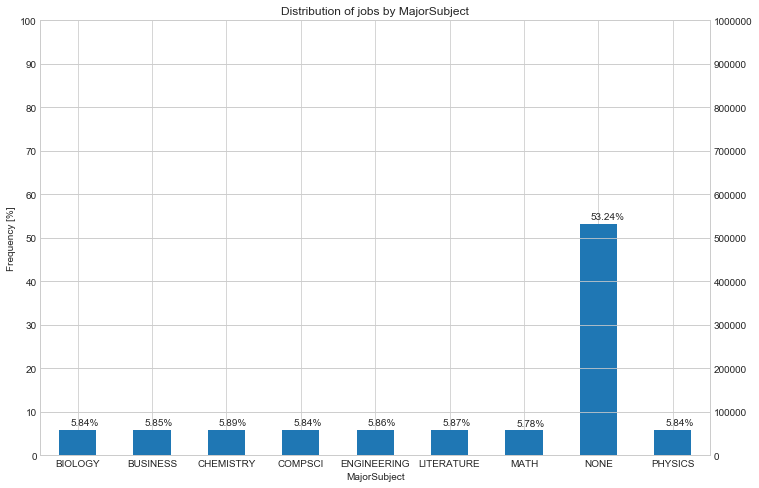

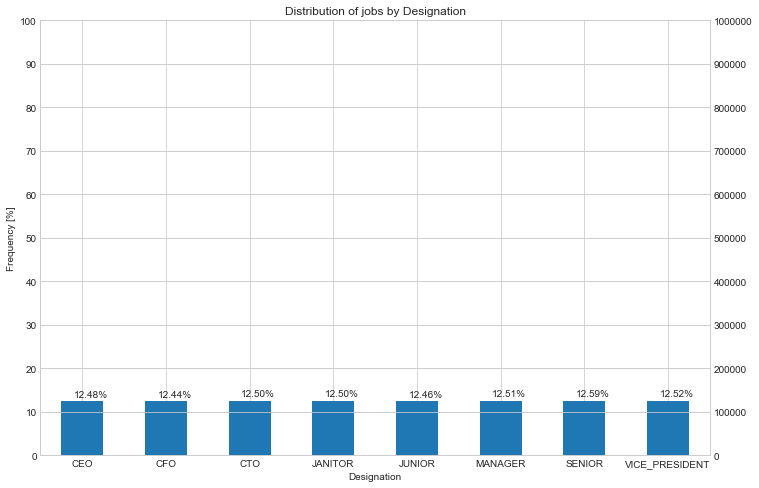

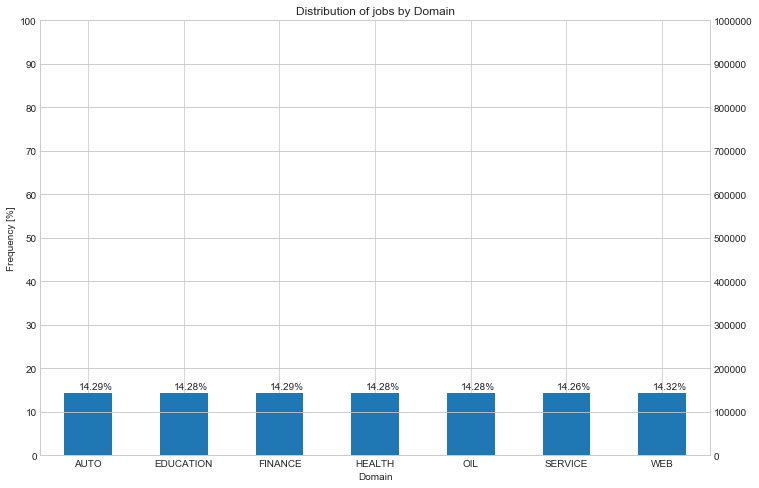

In [36]:
f.check_distribution('HighestDegree', dataset)
f.check_distribution('MajorSubject', dataset)
f.check_distribution('Designation', dataset)
f.check_distribution('Domain', dataset)

** Boxplot Analysis **

* **Salaries are highest in Engineering and Computer Science and are lowest in the field of literature**
* **Doctoral holders earn the highest followed by masters**
* **Top earning designations are chief executives, finance and technology officers followed by the vice presidents**
* **Finance and oil are the highest earning domains followed by healthcare with education being the lowest**


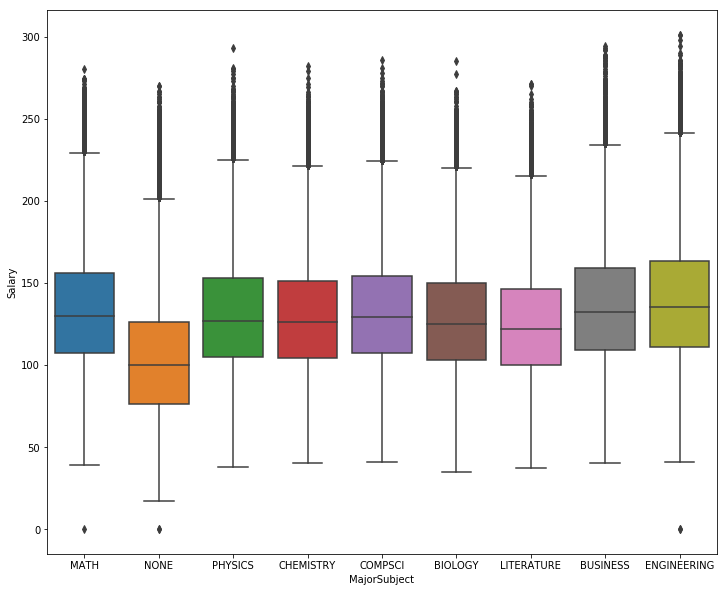

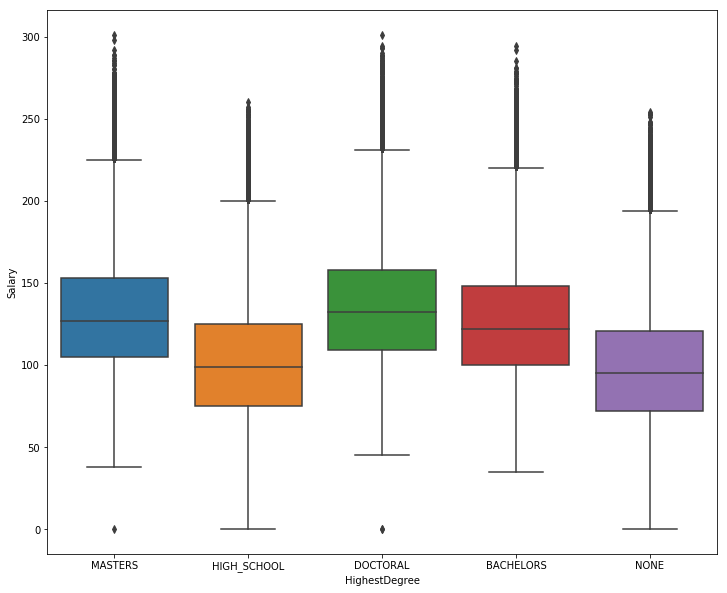

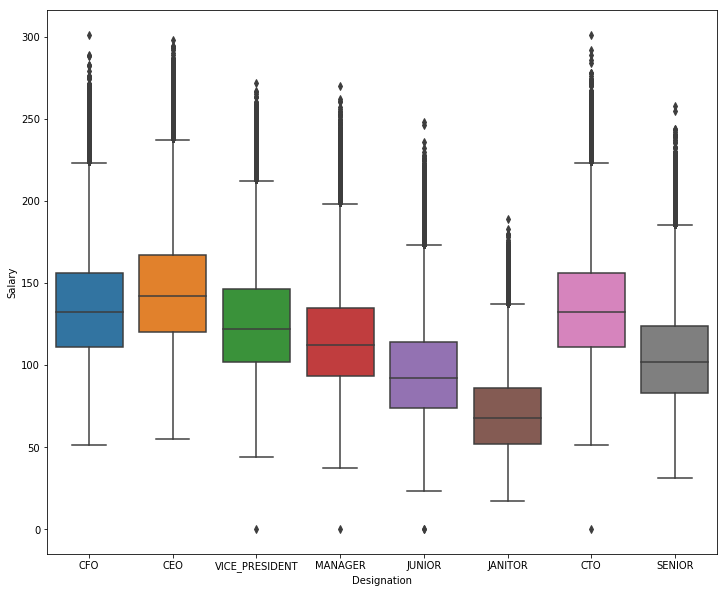

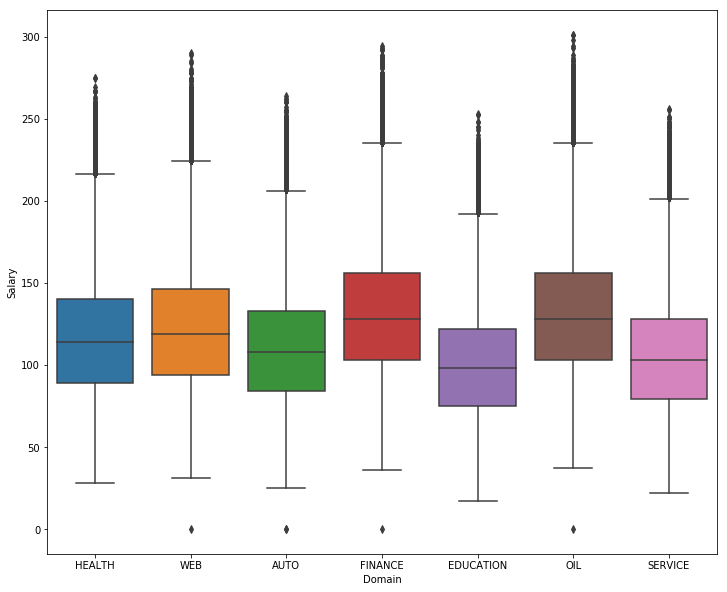

In [12]:
f.check_boxplot("MajorSubject", "Salary", dataset)
f.check_boxplot("HighestDegree", "Salary", dataset)
f.check_boxplot("Designation", "Salary", dataset)
f.check_boxplot("Domain", "Salary", dataset)

**Exploring continuous variables**

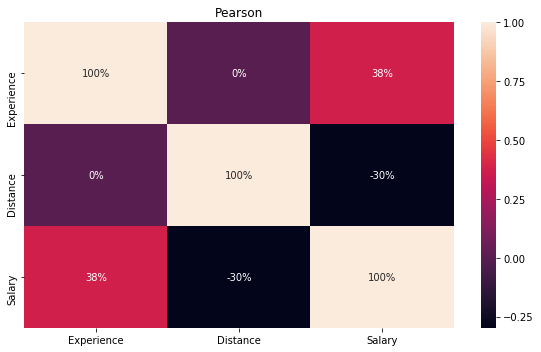

In [13]:
continuous_only = dataset[['Experience', 'Distance', 'Salary']]
f.create_corrmap(continuous_only)

In [37]:
dataset.describe()

,Experience,Distance,Salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


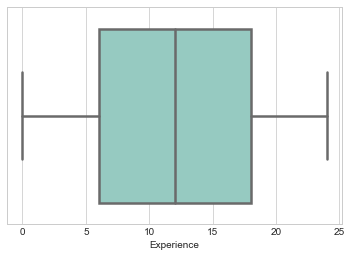

In [38]:
sns.set_style("whitegrid")
ax = sns.boxplot(x=dataset.Experience, palette="Set3", linewidth=2.5)

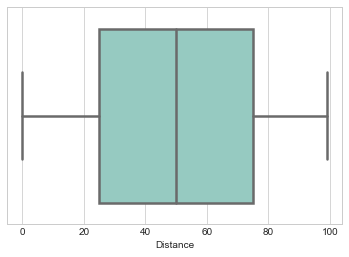

In [39]:
sns.set_style("whitegrid")
ax = sns.boxplot(x=dataset.Distance, palette="Set3", linewidth=2.5)

**Feature Engineering**<br>
1. Job code has no role to play in the prediction

In [40]:
dp = data_preparation()

In [41]:
dp.drop_nan_col(dataset, 0.9)

Jobcode does not have more than 90.0 missing values
Company does not have more than 90.0 missing values
Experience does not have more than 90.0 missing values
Distance does not have more than 90.0 missing values
HighestDegree does not have more than 90.0 missing values
MajorSubject does not have more than 90.0 missing values
Designation does not have more than 90.0 missing values
Domain does not have more than 90.0 missing values
Salary does not have more than 90.0 missing values


,Jobcode,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,JOB1362684407687,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,JOB1362684407688,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,JOB1362684407689,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,JOB1362684407690,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,JOB1362684407691,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163


In [42]:
dp.drop_zero_var_col(dataset)

Experience has values that have zero variance hence it will not be removed
Distance has values that have zero variance hence it will not be removed
Salary has values that have zero variance hence it will not be removed


,Jobcode,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,JOB1362684407687,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,JOB1362684407688,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,JOB1362684407689,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,JOB1362684407690,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,JOB1362684407691,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163


In [43]:
dir(dp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'drop_high_levels',
 'drop_nan_col',
 'drop_zero_car_col',
 'drop_zero_var_col',
 'encode_target',
 'replace_missing']

In [45]:
dp.drop_high_levels(dataset, 100)

,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163
5,C15,2,31,DOCTORAL,COMPSCI,MANAGER,FINANCE,113
6,C15,23,24,NONE,NONE,CFO,HEALTH,178
7,C24,9,70,BACHELORS,CHEMISTRY,JUNIOR,EDUCATION,73
8,C20,1,54,HIGH_SCHOOL,NONE,JANITOR,EDUCATION,31
9,C41,17,68,BACHELORS,CHEMISTRY,VICE_PRESIDENT,AUTO,104
